In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
monet_dir = '../Data/monet_jpg'
other_images_dir = '../Data/photo_jpg'

In [3]:
monet_images = ['monet_jpg/' + d for d in os.listdir(monet_dir)]

In [4]:
other_images = ['photo_jpg/' + d for d in os.listdir(other_images_dir)]

In [5]:
df_images = pd.DataFrame(
    columns=['location','label'],
    data=np.array([monet_images+other_images,[1 for i in monet_images]+[0 for i in other_images]]).T
)

In [6]:
val_counts = df_images['label'].value_counts()

In [7]:
df_images = pd.concat(
    [
        df_images,
        df_images[df_images['label']=='1'].sample(val_counts['0']-val_counts['1'], replace=True)
    ]
)

In [8]:
#df_images['label'] = df_images['label'].astype(int)

In [9]:
#create the training and validation subsets
train_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train_generator=train_datagen.flow_from_dataframe(
    dataframe=df_images,
    directory="../Data/",
    x_col="location",
    y_col="label",
    batch_size=25,
    seed=42,
    shuffle=True,
    class_mode="binary"
)

Found 14076 validated image filenames belonging to 2 classes.


In [10]:
for x,y in train_generator:
    break

In [11]:
example_monet = [im for i,im in enumerate(x) if y[i] == 1]
example_other = [im for i,im in enumerate(x) if y[i] == 0]

monet paintings

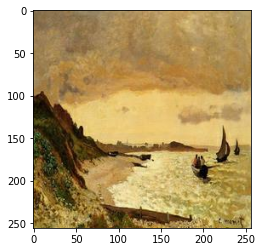

In [12]:
plt.imshow(example_monet[0])

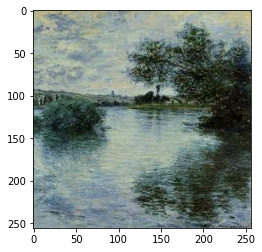

In [13]:
plt.imshow(example_monet[1])

Other pictures

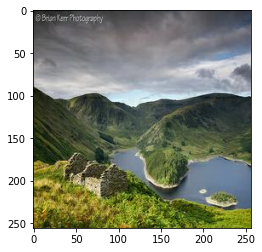

In [14]:
plt.imshow(example_other[0])

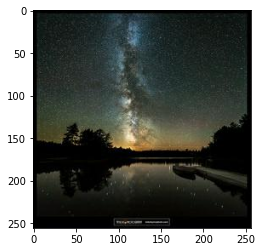

In [15]:
plt.imshow(example_other[1])

In [16]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same", activation='relu'),
        layers.AveragePooling2D(pool_size=(2,2),strides=(2,2)),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same", activation='relu'),
        layers.AveragePooling2D(pool_size=(2,2),strides=(2,2)),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same", activation='relu'),
        layers.AveragePooling2D(pool_size=(2,2),strides=(2,2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Metal device set to: Apple M1 Max
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 256, 256, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      3136      
                                                                 
 average_pooling2d (AverageP  (None, 64, 64, 64)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                   

2022-08-03 17:02:53.847931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-03 17:02:53.848053: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 16),
        layers.Reshape((8, 8, 16)),
        layers.Conv2DTranspose(32, kernel_size=4, strides=4, padding="same", activation='relu'),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation='relu'),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", activation='relu'),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", activation='relu'),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1024)              132096    
                                                                 
 reshape (Reshape)           (None, 8, 8, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 32)       8224      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 64)       32832     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 128)    131200    
 ranspose)                                                       
                                                         

In [18]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, data):
        # Sample random points in the latent space
        real_images, real_labels = data
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.reshape(real_labels,(batch_size,1))], axis=0
        )

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size*2, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.ones((batch_size*2, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [19]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("../Data/generated/generated_img_%03d_%d.png" % (epoch, i))


In [20]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(),#learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(),#learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [21]:
epochs = 100

In [22]:
fit_history = gan.fit(
    train_generator, epochs=epochs, callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim)]
)

Epoch 1/100


2022-08-03 17:02:55.883901: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-03 17:02:56.538283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


564/564 [==============================] - 923s 2s/step - d_loss: 0.2545 - g_loss: 26.8534
Epoch 2/100
564/564 [==============================] - 919s 2s/step - d_loss: 0.2196 - g_loss: 26.2966
Epoch 3/100
564/564 [==============================] - 920s 2s/step - d_loss: 0.1131 - g_loss: 7.7269
Epoch 4/100
564/564 [==============================] - 921s 2s/step - d_loss: 0.0559 - g_loss: 8.8160
Epoch 5/100
564/564 [==============================] - 918s 2s/step - d_loss: 0.0412 - g_loss: 10.7859
Epoch 6/100
564/564 [==============================] - 921s 2s/step - d_loss: 0.0199 - g_loss: 11.3600
Epoch 7/100
564/564 [==============================] - 915s 2s/step - d_loss: 0.0197 - g_loss: 11.1688
Epoch 8/100
564/564 [==============================] - 921s 2s/step - d_loss: 0.0189 - g_loss: 12.9872
Epoch 9/100
564/564 [==============================] - 919s 2s/step - d_loss: 0.0218 - g_loss: 12.0152
Epoch 10/100
564/564 [==============================] - 925s 2s/step - d_loss: 0.0505 -

KeyboardInterrupt: 